In [1]:
import os 
import h5py 
import emcee
import numpy as np 
import corner as DFM 
from time import time
# --- gqp_mc ---
from astrologs.astrologs import Astrologs

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(1)

TFP Version 0.11.1
TF  Version 2.3.1


In [4]:
nsa = Astrologs('nsa')

In [14]:
# compile photometry from NSA
lognmgy = np.log10(nsa.data['NMGY'][:,2:]) # optical photometry

# compile galaxy properties
#nsersic = nsa.data['SERSIC_N'].reshape(-1,1)
logmstar = np.log10(nsa.data['MASS']).reshape(-1,1)
#logmetal = np.log10(nsa.data['METS']).reshape(-1,1)

/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [15]:
#_X = np.concatenate([lognmgy, nsersic, logmstar, logmetal], axis=1)
_X = np.concatenate([lognmgy, logmstar], axis=1)

isnan = np.zeros(_X.shape[0]).astype(bool)
for _x in _X.T: 
    isnan = isnan | ~np.isfinite(_x) | np.isnan(_x)
X = tf.convert_to_tensor(_X[~isnan,:][:10000,:], dtype=tf.float32)

In [16]:
class Mask_AR(tf.keras.models.Model):
    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # Defining the bijector
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer

        for i in range(num_blocks): 
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            
            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 

        #bijectors.append(tfb.Log())

        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)

In [20]:
maf = Mask_AR(output_dim=X.shape[1], num_masked=1, n_bijectors=5, hidden_layer=20)
_ = maf(X)
print(maf.summary())

Model: "mask_ar_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 4,060
Trainable params: 4,060
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf.flow.log_prob(X))


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()
for i in range(int(1e3+1)):
    loss = train_step(maf, maf_optimizer, X)
    #for batch in batches:
    #    loss = train_step(maf, maf_optimizer, batch)
        
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   34.799892 2.8434550762176514
100   11.601972 1.494267225265503
200   4.856326 1.4338407516479492
300   -0.8124956 1.5157241821289062
400   -3.3693688 1.4671549797058105
500   -4.4302454 1.5420877933502197
600   -4.7374353 1.4762816429138184
700   -5.164299 1.4874379634857178
800   -5.4016576 1.4035649299621582
900   -5.474929 1.405318260192871
1000   -5.550525 1.4054410457611084


In [22]:
Z = np.random.normal(0,1,(10000, _X.shape[1]))
_maf_samples = maf(Z).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



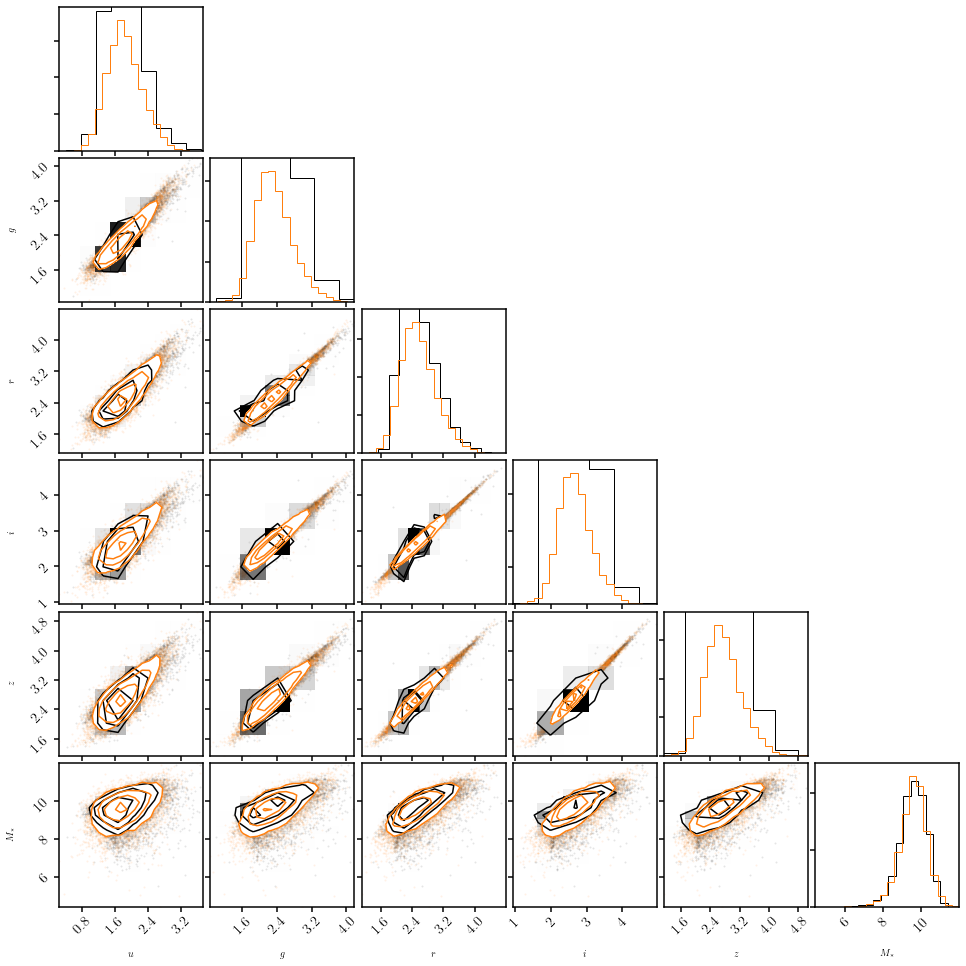

In [23]:
fig = DFM.corner(X.numpy(), color='k', 
                 labels=[r"$u$", r'$g$', r'$r$', r'$i$', r'$z$', r'$M_*$'], 
                 plot_density=True)
_ = DFM.corner(_maf_samples, color='C1', fig=fig, plot_density=False)

In [24]:
X_test = tf.convert_to_tensor(_X[~isnan,:][10000:11000,:], dtype=tf.float32)

In [25]:
def logPosterior(prop, photometry=None): 
    ''' posterior p( property | photometry)
    '''
    return maf.flow.log_prob(np.concatenate([photometry, prop])).numpy()

In [26]:
dX = (X.numpy().max(axis=0) - X.numpy().min(axis=0))

In [32]:
ndim, nwalkers = 1, 5

chains = []
for i, _X_test in enumerate(X_test.numpy()[:10]): 
    print('galaxy %i' % i)
    p0 = _X_test[-1] + 1e-3 * dX[-1] * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, kwargs={'photometry': _X_test[:-1]})
    sampler.run_mcmc(p0, 500)
    chain = sampler.get_chain()

    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    chains.append(chain.reshape(s))

galaxy 0
galaxy 1
emcee: Exception while calling your likelihood function:
  params: [9.45381318]
  args: []
  kwargs: {'photometry': array([1.7633592, 2.4304895, 2.7502635, 2.8863142, 3.052175 ],
      dtype=float32)}
  exception:


Traceback (most recent call last):
  File "/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-25-dba8b77a1a17>", line 4, in logPosterior
    return maf.flow.log_prob(np.concatenate([photometry, prop])).numpy()
  File "/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py", line 964, in log_prob
    return self._call_log_prob(value, name, **kwargs)
  File "/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py", line 946, in _call_log_prob
    return self._log_prob(value, **kwargs)
  File "/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/tensorflow_probability/python/distributions/transformed_distribution.py", line 520, in _log_prob
    base_is_scalar_batch, **distribution_kwargs)
  File "/Users/Chan

KeyboardInterrupt: 

In [36]:
for i, _X_test in enumerate(X_test.numpy()[1:5]): 
    print('galaxy %i' % i)
    p0 = _X_test[-1] + 1e-3 * dX[-1] * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, kwargs={'photometry': _X_test[:-1]})
    sampler.run_mcmc(p0, 500)
    chain = sampler.get_chain()

    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    chains.append(chain.reshape(s))

galaxy 0
galaxy 1
galaxy 2
galaxy 3


In [41]:
logM_true = X_test[:len(chains),-1].numpy()
logM_NF = np.median(chains, axis=1)
logM_NF_m1sig, logM_NF_p1sig = np.quantile(chains, [0.16, 0.84], axis=1)

In [42]:
logM_true

array([10.796177, 10.128673,  9.512755, 10.235168, 10.633495],
      dtype=float32)

/Users/ChangHoon/opt/anaconda3/envs/iq/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(6.0, 12.0)

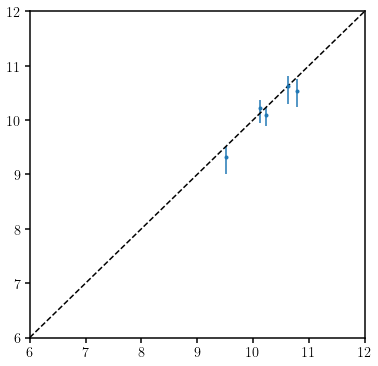

In [44]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.errorbar(logM_true, logM_NF, yerr=[logM_NF - logM_NF_m1sig, logM_NF_p1sig - logM_NF], fmt='.C0')
sub.plot([6., 12.], [6., 12.], ls='--', c='k')
sub.set_xlim(6, 12)
sub.set_ylim(6, 12)